## Train/Test Split

In [1]:
import os
import sys
sys.path.append("/home/martin/Dev/homography_imitation_learning")
import pandas as pd
from utils.processing import unique_video_train_test

prefix = "/media/martin/Samsung_T5/data/endoscopic_data/21_11_25_first_test_data_frames"
in_pkl = "pre_processed_10th_frame_log"

df = pd.read_pickle(os.path.join(prefix, in_pkl + ".pkl"))
df = unique_video_train_test(df, tolerance=0.35)
df.to_pickle(os.path.join(prefix, in_pkl + "_test_train.pkl"))

/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Labels Dataframe

In [6]:
import os
import sys
sys.path.append("/home/martin/Dev/homography_imitation_learning")
import numpy as np
import pandas as pd
from utils.io import recursive_scan2df

prefix = "/media/martin/Samsung_T5/data/endoscopic_data/cholec80_frames"
in_pkl = "22_11_21_deep_log_pre_processed_test_train"
out_pkl = "22_11_21_deep_log_pre_processed_test_train_labels"

df = pd.read_pickle(os.path.join(prefix, in_pkl + ".pkl"))
label_df = pd.DataFrame()

phase_prefix = "/media/martin/Samsung_T5/data/endoscopic_data/cholec80/phase_annotations"
tool_annotation_prefix = "/media/martin/Samsung_T5/data/endoscopic_data/cholec80/tool_annotations"

phase_df = recursive_scan2df(phase_prefix, ".txt")
tool_annotation_df = recursive_scan2df(tool_annotation_prefix, ".txt")

phase_df, tool_annotation_df = phase_df.sort_values("file").reset_index(drop=True), tool_annotation_df.sort_values("file").reset_index(drop=True)
phase_df["vid"], tool_annotation_df["vid"] = phase_df.file.apply(lambda x: int(x.split("-")[0][-2:]) - 1), tool_annotation_df.file.apply(lambda x: int(x.split("-")[0][-2:]) - 1)

for (idx, phase_txt_row), (_, tool_annotation_txt_row) in zip(phase_df.iterrows(), tool_annotation_df.iterrows()):
    if not phase_txt_row.vid in df.vid.unique():
        print("Skipping vid {}".format(phase_txt_row.vid))
        continue

    phase_txt = pd.read_csv(os.path.join(phase_prefix, phase_txt_row.folder, phase_txt_row.file), sep="\t")
    tool_annotation_txt = pd.read_csv(os.path.join(tool_annotation_prefix, tool_annotation_txt_row.folder, tool_annotation_txt_row.file), sep="\t")

    # correct padded end
    phase_txt = phase_txt[:len(df[df.vid == idx])].reset_index(drop=True)
    tool_annotation_txt = tool_annotation_txt[:len(df[df.vid == idx])].reset_index(drop=True)

    if len(df[df.vid == idx]) != len(phase_txt):
        # raise RuntimeError("Wrong length at index {}, {}/{}.".format(idx, len(df[df.vid == idx]), len(phase_txt)))
        print("Wrong length at index {}, {}/{}.".format(idx, len(df[df.vid == idx]), len(phase_txt)))
        phase_txt = phase_txt[:-1]
        # phase_txt.to_csv(os.path.join(phase_prefix, phase_txt_row.folder, phase_txt_row.file), sep="\t")

    # fill missing annotations

    # tmp = phase_txt.iloc[tool_annotation_txt.Frame] #pd.concat([phase_txt, tool_annotation_txt])
    tmp = phase_txt.set_index("Frame").join(tool_annotation_txt.set_index("Frame"))
    # tmp = phase_txt.join(tool_annotation_txt, on="Frame", lsuffix="_phase", rsuffix="_tool_annotation", sort=True)
    label_df = label_df.append(tmp)
    if len(label_df.columns) > 8:
        print(idx, " Merge: ", len(label_df.columns), " phase: ", len(phase_txt.columns), " tool:  ", len(tool_annotation_txt.columns))


label_df["Frame"] = label_df.index
label_df = label_df.reset_index(drop=True)
print(label_df)
label_df.to_pickle(os.path.join(prefix, out_pkl))




Scanning /media/martin/Samsung_T5/data/endoscopic_data/cholec80/phase_annotations recursively for .txt files
Scanning /media/martin/Samsung_T5/data/endoscopic_data/cholec80/tool_annotations recursively for .txt files
Skipping vid 1
Skipping vid 2
Skipping vid 3
Skipping vid 5
Skipping vid 6
Skipping vid 7
Skipping vid 8
Skipping vid 9
Skipping vid 11
Skipping vid 13
Skipping vid 14
Skipping vid 15
Skipping vid 16
Skipping vid 17
Skipping vid 19
Skipping vid 20
Skipping vid 21
Skipping vid 22
Skipping vid 23
Skipping vid 24
Skipping vid 25
Skipping vid 26
Skipping vid 27
Skipping vid 28
Skipping vid 30
Skipping vid 31
Skipping vid 32
Skipping vid 33
Skipping vid 34
Skipping vid 35
Skipping vid 36
Skipping vid 37
Skipping vid 38
Skipping vid 39
Skipping vid 40
Skipping vid 41
Skipping vid 42
Skipping vid 43
Skipping vid 44
Skipping vid 45
Skipping vid 46
Skipping vid 47
Skipping vid 48
Skipping vid 49
Skipping vid 50
Skipping vid 51
Skipping vid 52
Skipping vid 53
Skipping vid 54
Skippin

/home/martin/Dev/homography_imitation_learning/utils/io/folders.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dic_list, ignore_index=True)
/home/martin/Dev/homography_imitation_learning/utils/io/folders.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dic_list, ignore_index=True)
/tmp/ipykernel_1009240/1918253220.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(tmp)
/tmp/ipykernel_1009240/1918253220.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(tmp)
/tmp/ipykernel_1009240/1918253220.py:47: FutureWarning: The frame.append method is d

# Remove Nan

In [2]:
import os
import pandas as pd

toy = True

if toy:
    prefix = "/media/martin/Samsung_T5/data/endoscopic_data/21_11_25_first_test_data_frames"
    data_pkl = "pre_processed_10th_frame_log_test_train"
else:
    prefix = "/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped"
    data_pkl = "22_11_09_loftr_pre_processed_frame_increment_5_frames_between_clips_5_log_test_train"
    label_pkl = "22_11_09_loftr_pre_processed_frame_increment_5_frames_between_clips_5_log_test_train_labels"

df = pd.read_pickle(os.path.join(prefix, data_pkl) + ".pkl")
valid = ~df.duv_mpd.isna().values

print(len(df))
df = df[valid]
print(len(df), len(df.vid.unique())*5)

df.to_pickle(os.path.join(prefix, data_pkl) + "_no_nan.pkl")

if not toy:
    label_df = pd.read_pickle(os.path.join(prefix, label_pkl) + ".pkl")
    print(len(label_df) - len(df))
    label_df = label_df[valid]
    print(len(label_df) - len(df))

    label_df.to_pickle(os.path.join(prefix, label_pkl) + "_no_nan.pkl")

7460
740 50


## Load and Check

In [5]:
import os
import pandas as pd

prefix = "/media/martin/Samsung_T5/data/endoscopic_data/21_11_25_first_test_data_frames"
data_pkl = "pre_processed_10th_frame_log_test_train_no_nan"
label_pkl = "22_11_09_loftr_pre_processed_frame_increment_5_frames_between_clips_5_log_test_train_labels"

df = pd.read_pickle(os.path.join(prefix, data_pkl + ".pkl"))
print("Log:")
print(df)
# df = pd.read_pickle(os.path.join(prefix, label_pkl + ".pkl"))
# print("Labels:")
# print(df)



Log:
       folder           file vid frame                  center     radius  \
0     split_0    frame_0.npy   0     0   [567.7546, 978.94995]  467.79523   
10    split_0   frame_10.npy   0    10   [567.7546, 978.94995]  467.79523   
20    split_0   frame_20.npy   0    20   [567.7546, 978.94995]  467.79523   
30    split_0   frame_30.npy   0    30   [566.78424, 978.6424]   468.6956   
40    split_0   frame_40.npy   0    40   [566.78424, 978.6424]   468.6956   
...       ...            ...  ..   ...                     ...        ...   
7404  split_9  frame_690.npy   9   690  [541.03107, 989.49176]  467.28677   
7414  split_9  frame_700.npy   9   700  [541.03107, 989.49176]  467.28677   
7424  split_9  frame_710.npy   9   710  [541.03107, 989.49176]  467.28677   
7434  split_9  frame_720.npy   9   720    [541.1453, 989.3263]    468.129   
7444  split_9  frame_730.npy   9   730    [541.1453, 989.3263]    468.129   

      train                                                duv   duv_m

# Visualize Data

Loading index 5
Four point homography:
 tensor([[[-1.7523, -0.1754],
         [-0.2863,  0.5614],
         [-3.1211,  0.2109],
         [-3.4379,  0.4607]]])
torch.Size([1, 4, 2])


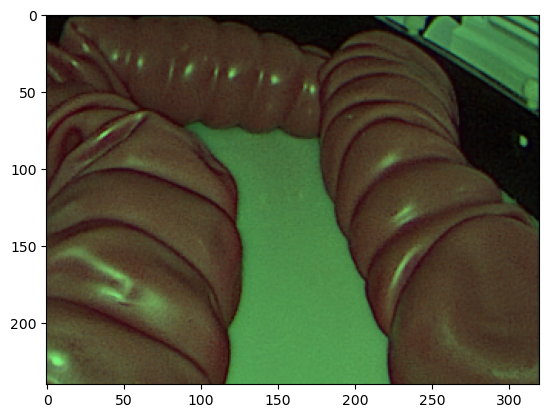

In [39]:
import sys
sys.path.append("../..")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from kornia.geometry import warp_perspective
from kornia import image_to_tensor, tensor_to_image
from utils.viz import create_blend_from_four_point_homography

prefix = "/media/martin/Samsung_T5/data/endoscopic_data/21_11_25_first_test_data_frames"
data_pkl = "pre_processed_10th_frame_log_test_train_no_nan"

df = pd.read_pickle(os.path.join(prefix, data_pkl + ".pkl"))

idx = np.random.randint(0, len(df)-1) # want to sample warp
print(f"Loading index {idx}")
duv = torch.tensor(df.iloc[idx].duv).unsqueeze(0)

print("Four point homography:\n", duv)
print(duv.shape)

img = np.load(os.path.join(prefix, df.iloc[idx].folder, df.iloc[idx].file))
wrp = np.load(os.path.join(prefix, df.iloc[idx+1].folder, df.iloc[idx+1].file))
img, wrp = image_to_tensor(img, False).float()/255., image_to_tensor(wrp, False).float()/255.

blend = create_blend_from_four_point_homography(img, wrp, duv)
blend = (tensor_to_image(blend, False)*255.).astype(np.uint8)

plt.imshow(blend)
plt.show()



# Check Size

In [ ]:
import os
import pandas as pd
import numpy as np
import math

prefix = "/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped"
data_pkl = "pre_processed_5th_frame_log_new_test_train_no_nan"

df = pd.read_pickle(
    os.path.join(prefix, data_pkl) + ".pkl"
)

df.duv_mpd = df.duv_mpd.apply(lambda x: np.single(x))
df.vid = pd.to_numeric(df.vid, downcast='integer')
df.frame = pd.to_numeric(df.frame, downcast='integer')
df.duv = df.duv.apply(lambda x: [list(map(np.single, xi)) for xi in x] if x == x else x)

print(df.info(memory_usage="deep"))
df.to_pickle(os.path.join(prefix, data_pkl + "_compressed.pkl"))

In [ ]:
import os
import numpy as np
import pandas as pd

prefix = "/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped"
data_pkl = "pre_processed_5th_frame_log_test_train"

df = pd.read_pickle(
    os.path.join(prefix, data_pkl) + ".pkl"
)

df.duv_mpd = df.duv_mpd.apply(lambda x: np.single(x))
df.vid = pd.to_numeric(df.vid, downcast='integer')
df.frame = pd.to_numeric(df.frame, downcast='integer')
df.duv = df.duv.apply(lambda x: [list(map(np.float16, xi)) for xi in x] if x == x else x)

print(df.info(memory_usage="deep"))
df.to_pickle(os.path.join(prefix, data_pkl + "_compressed.pkl"))

In [ ]:
import pandas as pd

prefix = "/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped"
df = pd.read_pickle(prefix + "/pre_processed_5th_frame_log_new_test_train_no_nan_compressed.pkl")
print(df.info(memory_usage="deep"))

In [ ]:
import pandas as pd

prefix = "/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped"
df = pd.read_pickle(prefix + "/pre_processed_5th_frame_log_test_train_compressed.pkl")
print(df.info(memory_usage="deep"))